## Image segmentation with fastai

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [2]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/img_wmasks'
path_lbl = path+'/data/h5/masks2'

## Data

In [3]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/9370400_5518400.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/8589200_5538000.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/8507600_5765200.png')]

In [4]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/9295200_5556000_mask.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/8820000_5988800_mask.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/9301600_5562000_mask.tif')]

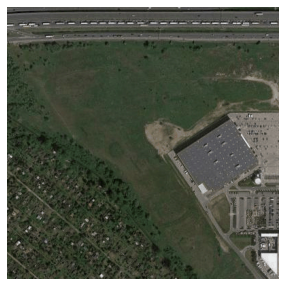

In [5]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'

In [7]:
lbl_names[1]

PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/8820000_5988800_mask.tif')

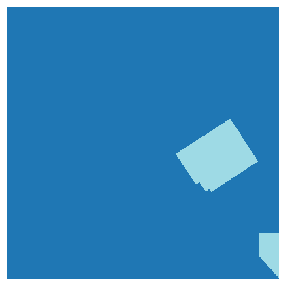

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 400]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
mask.size

torch.Size([400, 400])

In [11]:
codes = array(['Background' , 'Building'])

In [12]:
codes

array(['Background', 'Building'], dtype='<U10')

In [13]:
mask.data.sum()

tensor(8457)

## Datasets

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7586MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [18]:
data.valid_dl = data.valid_dl.new(shuffle=True)

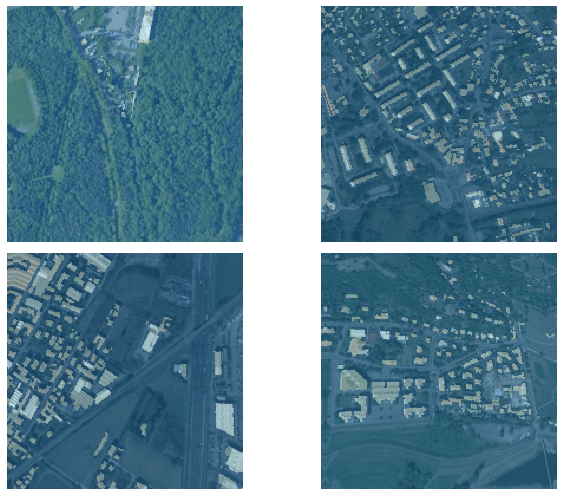

In [19]:
data.show_batch(2, figsize=(10,7))

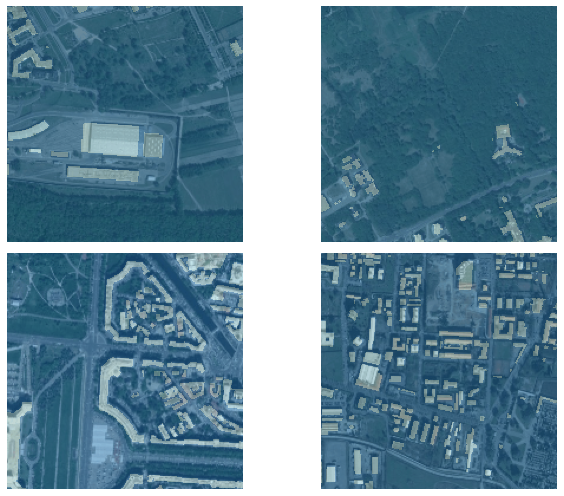

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
metrics=acc_camvid

In [23]:
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


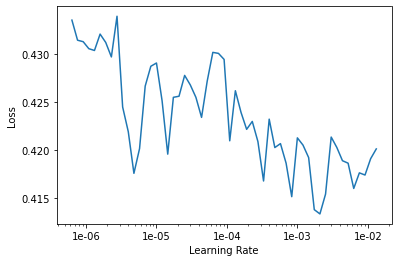

In [30]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.265417,0.243372,0.324725,03:31
1,0.246922,0.250347,0.514362,03:17
2,0.232454,0.220808,0.490394,03:17
3,0.227873,0.216771,0.508521,03:17
4,0.229264,0.215252,0.536646,03:18
5,0.226656,0.218778,0.496708,03:18
6,0.232239,0.217728,0.561472,03:18
7,0.228866,0.212635,0.578099,03:18
8,0.213661,0.208962,0.576201,03:19
9,0.206083,0.197514,0.572087,03:18


In [33]:
learn.save('stage-1')

In [34]:
learn.load('stage-1');

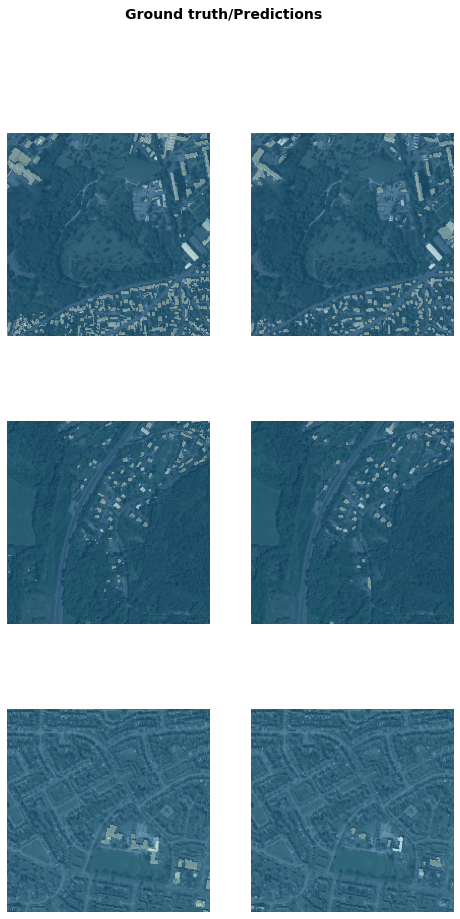

In [35]:
learn.show_results(rows=3, figsize=(8,15))

In [36]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [38]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.206849,0.196173,0.561892,03:37
1,0.195588,0.196012,0.578121,03:30
2,0.194290,0.194718,0.584786,03:30
3,0.203412,0.193067,0.568944,03:31
4,0.193004,0.192269,0.571688,03:31
5,0.202558,0.192248,0.574433,03:31
6,0.202170,0.192402,0.561554,03:31
7,0.186901,0.194372,0.536761,03:34
8,0.204457,0.191367,0.547763,03:31
9,0.196480,0.192179,0.604182,03:31


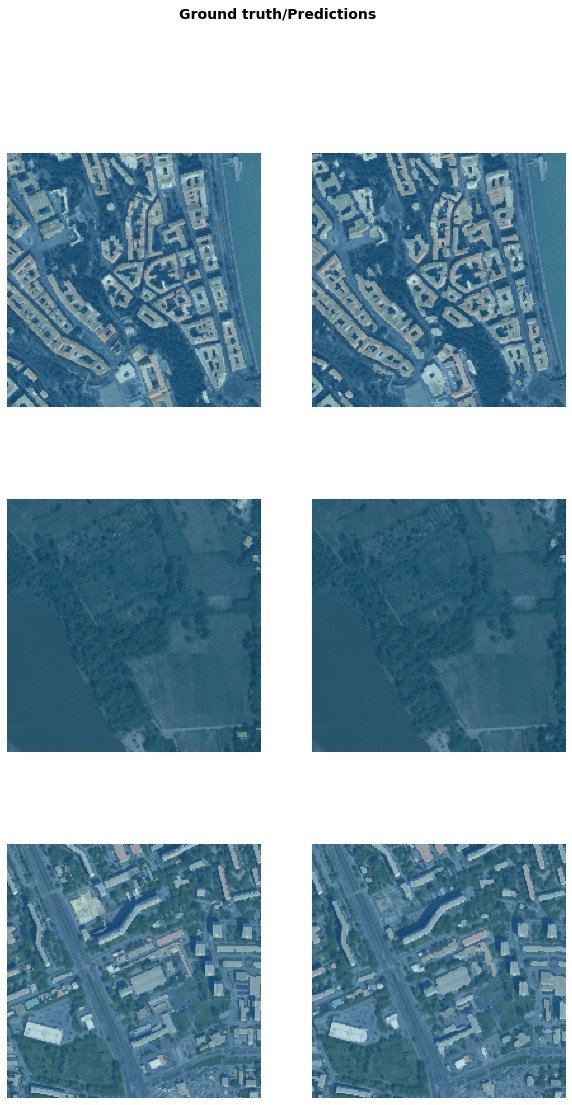

In [40]:
learn.show_results(rows=3, figsize=(10,18))

In [42]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [26]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=3
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 6987MB of GPU RAM free


In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [46]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


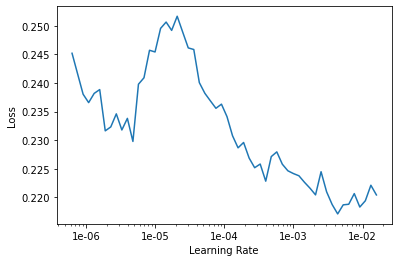

In [47]:
lr_find(learn)
learn.recorder.plot()

In [48]:
lr=1e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.192988,0.194877,0.563373,11:03
1,0.206289,0.189780,0.586875,11:00
2,0.197930,0.188354,0.594897,11:00
3,0.183384,0.187282,0.636533,11:01
4,0.188211,0.185410,0.616907,11:01
5,0.196201,0.183721,0.607978,11:03
6,0.195956,0.181219,0.601281,11:01
7,0.180226,0.181549,0.616118,11:01
8,0.195746,0.179340,0.641098,11:00
9,0.180412,0.176606,0.623988,11:01


In [50]:
learn.save('stage-1-big')

In [29]:
learn.load('stage-1-big');

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.178157,0.177290,0.627877,23:40
1,0.194858,0.184552,0.541604,23:35
2,0.174221,0.235006,0.601460,23:36
3,0.208536,0.201562,0.565716,23:37
4,0.190903,0.184813,0.603753,23:36
5,0.180338,0.194739,0.575114,23:36
6,0.194246,0.205351,0.607111,23:37
7,0.173586,0.268123,0.581080,23:37
8,0.186383,0.388126,0.591671,23:37
9,0.195230,0.969050,0.591985,23:37


In [33]:
learn.save('stage-2-big')

In [34]:
learn.load('stage-2-big');

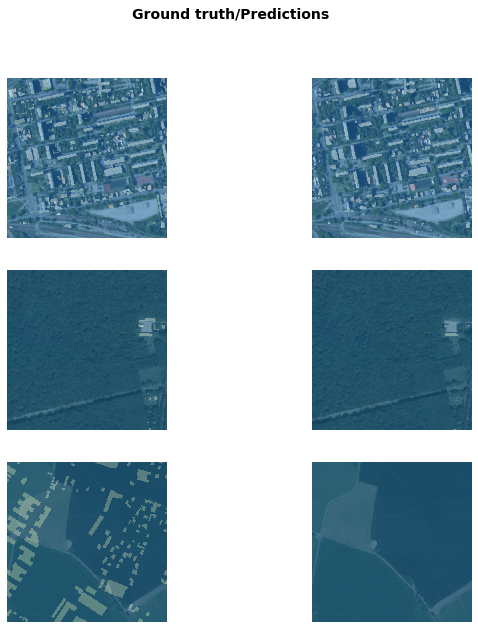

In [35]:
learn.show_results(rows=3, figsize=(10,10))

## fin